# Testing EOF decomposition with dask using `xeofs` package

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.

Ultimately want to perform an analysis such as: https://doi.org/10.1175/2011JCLI3941.1 

Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

## 1. Access and load MUR data

In [1]:
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
print(earthaccess.__version__)
print(earthaccess.__file__)

0.5.3
/opt/coiled/env/lib/python3.11/site-packages/earthaccess/__init__.py


In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using user provided credentials for EDL


In [3]:
%%time

endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2007-12-31"),
    )

Granules found: 1177
CPU times: user 217 ms, sys: 15.6 ms, total: 233 ms
Wall time: 53.4 s


In [4]:
%%time

fileobjs = earthaccess.open(endpoints)

 Opening 1177 granules, approx size: 0.12 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

CPU times: user 1.88 s, sys: 99.7 ms, total: 1.98 s
Wall time: 5.57 s


**Found a weird result in one of the file objects:**

In [5]:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


**The above file does not show up in CMR: https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2036878116-POCLOUD/temporal**

This is worth looking into, but for now just remove this object from the list and continue:

In [6]:
fileobjs_good = [f for f in fileobjs if type(f) != FileNotFoundError]

In [7]:
print(len(fileobjs))
print(len(fileobjs_good))

1177
1176


#### **Can runtime of the below line be decreased using parallelization?**

In [8]:
%%time

sstdata = xr.open_mfdataset(fileobjs_good, chunks={})

CPU times: user 35.7 s, sys: 468 ms, total: 36.2 s
Wall time: 2min 58s


In [9]:
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lev: 1, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lev      (lev) float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
Data variables:
    sst      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 89, 180), meta=np.ndarray>
    ssta     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.190912
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [10]:
sstdata = sstdata.squeeze()
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.190912
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [12]:
#sst = sstdata['sst'].squeeze()

## 2. Detrend and Remove Seasonal Cycle

### 2.1 Linear Detrend

Using scipy.signal.detrend()...

In [13]:
sst = sstdata['sst'].values

In [14]:
# ...

In [15]:
# ...

### 2.2 Remove Seasonal Cycle

In [16]:
#sst.apply_ufunc(np.reshape(nt, nlat*nlon))

In [17]:
nt, nlat, nlon = sst.shape

In [18]:
#ssttest = sst.reshape((12, int(nt/12), nlat, nlon), order='F')
sst_detrend = sst.reshape((12, int(nt/12), nlat, nlon), order='F').transpose((1,0,2,3))

In [19]:
sst_seasonal = sst_detrend.mean(axis=0)

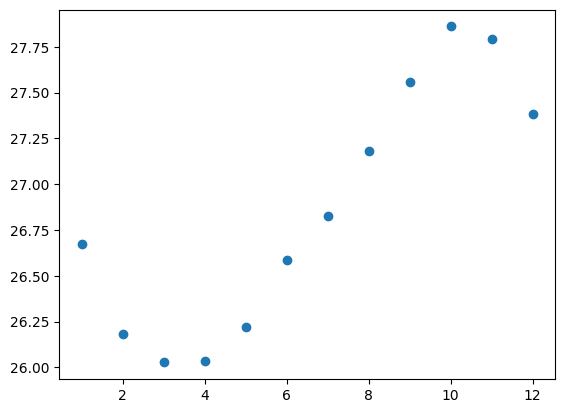

In [20]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 50, 100])

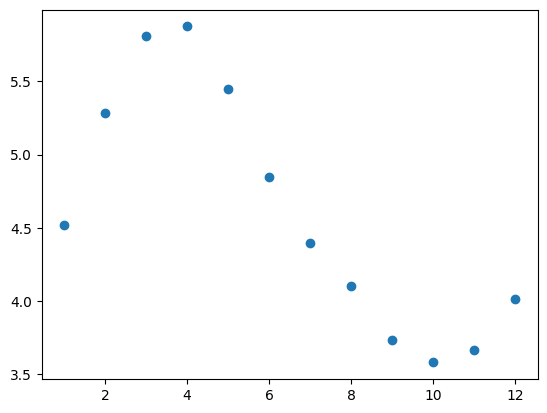

In [21]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 20, 20])

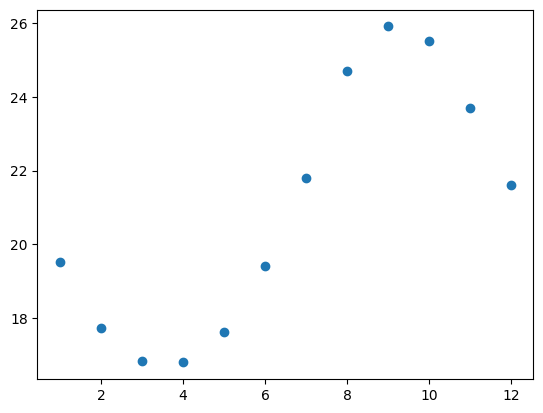

In [22]:
plt.scatter(np.arange(1,13), sst_seasonal[:, 60, 90])

In [23]:
sst_detrend = sst_detrend - sst_seasonal

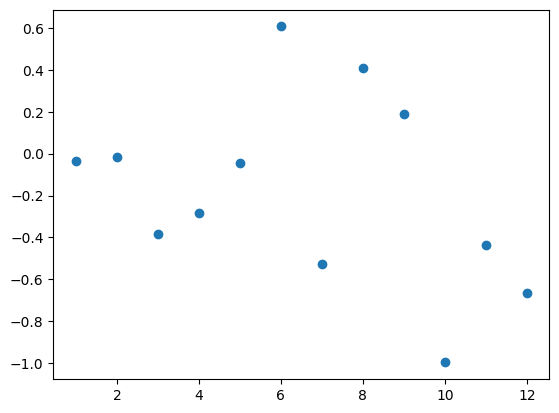

In [24]:
plt.scatter(np.arange(1,13), sst_detrend[2, :, 60, 90])

In [25]:
sst_detrend.shape

(98, 12, 89, 180)

In [26]:
sstdata['sst'].values = sst_detrend.reshape(nt, nlat, nlon)

## 3. EOF decomp

In [33]:
import xeofs as xe

In [41]:
%%time

model = xe.models.EOF(n_modes=10)
model.fit(sstdata['sst'], dim='time')

CPU times: user 359 ms, sys: 88.2 ms, total: 447 ms
Wall time: 447 ms


In [42]:
%%time

model.explained_variance_ratio().load()

CPU times: user 678 µs, sys: 0 ns, total: 678 µs
Wall time: 684 µs


<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.16010587, 0.08270318, 0.0405059 , 0.02948764, 0.02791134,
       0.02421397, 0.0222688 , 0.02088336, 0.01971043, 0.01908563],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-14 16:53:05

In [43]:
%%time

components = model.components().load()

CPU times: user 4.72 ms, sys: 8 µs, total: 4.73 ms
Wall time: 4.23 ms


In [44]:
components

<xarray.DataArray 'components' (mode: 10, lat: 89, lon: 180)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
          1.7255983e-08, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.4422787e-08,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.6053232e-09,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
    lev      float64 0.0
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-14 16:53:05

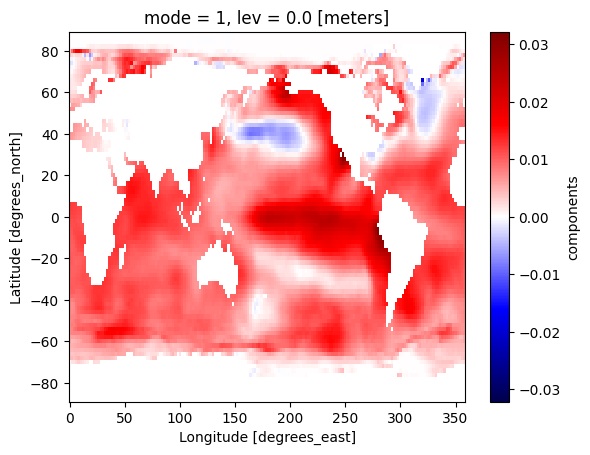

In [45]:
components.sel(mode=1).plot(cmap='seismic')

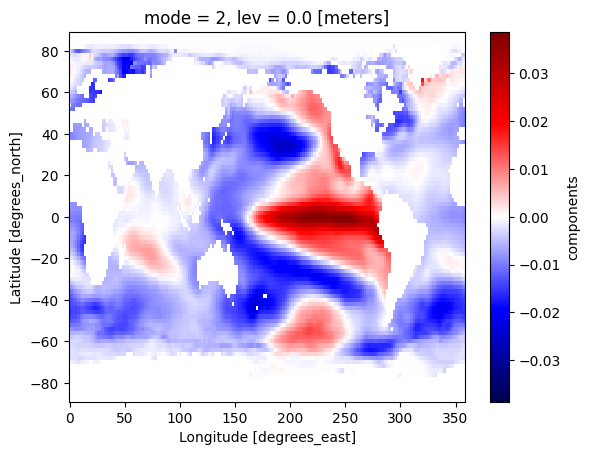

In [46]:
components.sel(mode=2).plot(cmap='seismic')

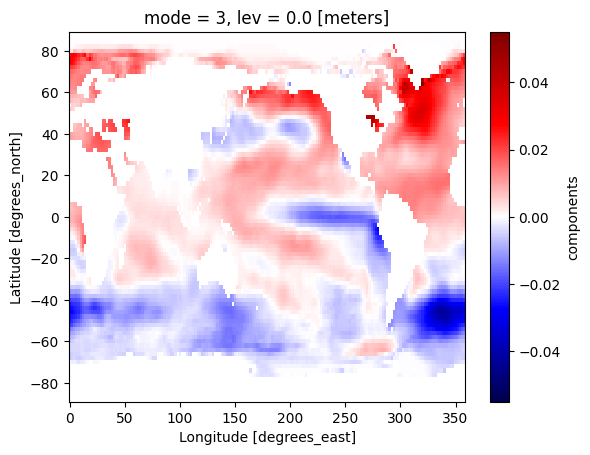

In [47]:
components.sel(mode=3).plot(cmap='seismic')

In [48]:
%%time

scores = model.scores().load()

CPU times: user 563 µs, sys: 7 µs, total: 570 µs
Wall time: 576 µs


ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

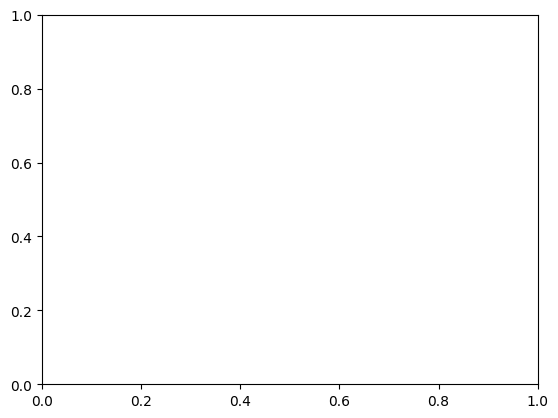

In [49]:
scores.sel(mode=1).plot()

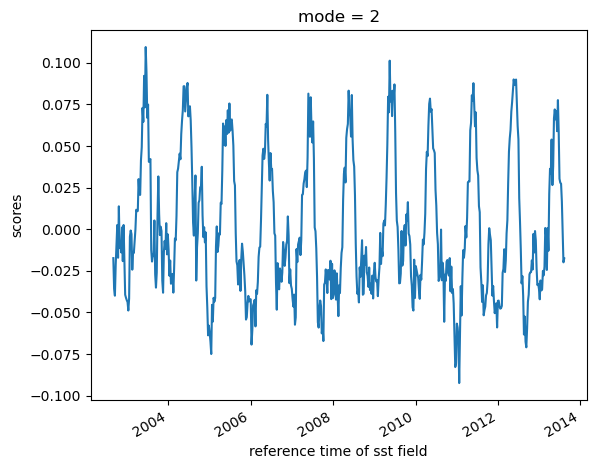

In [19]:
scores.sel(mode=2).plot()

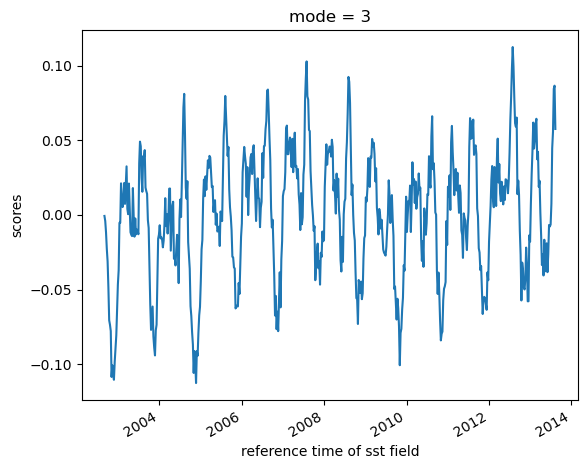

In [25]:
scores.sel(mode=3).plot()

## 4. EOF decomp with Dask

In [28]:
import coiled

In [29]:
cluster = coiled.Cluster(n_workers=10, region='us-west-2')

Output()

Package - coiled_local_working, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                        ╷                                                                         │
│   Package              │ Note                                                                    │
│ ╶──────────────────────┼───────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_synced  │ Source wheel built from /scratch/synced                                 │
│   coiled_local_working │ Source wheel built from                                                 │
│                        │ /opt/coiled/rt/.path-deps/coiled_local_working-0.0.0-py3-none-any.whl   │
│                        ╵                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                            ╷                                                        ╷            │
│   Package                  │ Error                                                  │ Risk       │
│ ╶──────────────────────────┼────────────────────────────────────────────────────────┼──────────╴ │
│   coiled_local_working     │ Built wheel does not contain all python files!         │ Warning    │
│                            ╵                                                        ╵            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [30]:
client = cluster.get_client()

In [31]:
client

<Client: 'tls://10.0.53.154:8786' processes=10 threads=40, memory=148.38 GiB>

In [40]:
client.shutdown()

In [11]:
from dask.distributed import Client, LocalCluster

In [12]:
client = Client()

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38015,Workers: 4
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:45299,Total threads: 1
Dashboard: https://cluster-cpnwk.dask.host/jupyter/proxy/39635/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:41045,


In [15]:
import xeofs as xe

In [19]:
sstdata['ssta'].mean().load()

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [16]:
model = xe.models.EOF(n_modes=10)
model.fit(sstdata['ssta'], dim='time')

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 120.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6943b90d60>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


RuntimeError: Error during deserialization of the task graph. This frequently occurs if the Scheduler and Client have different environments. For more information, see https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [35]:
evr = model.explained_variance_ratio()

In [36]:
evr

<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.16010582, 0.08270313, 0.04050592, 0.02948766, 0.02791134,
       0.02421374, 0.02226816, 0.02088275, 0.01971089, 0.01908752],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-09-14 20:54:42

In [38]:
sstdata['ssta']

<xarray.DataArray 'ssta' (time: 1176, lat: 89, lon: 180)>
dask.array<getitem, shape=(1176, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1909-12-01 00:00:00 ... 2007-11-01 00:00:00
Attributes:
    long_name:  Extended reconstructed SST anomalies
    units:      degree_C
    valid_min:  -12.0
    valid_max:  12.0